# imports

In [6]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# problem setup

\begin{align*}
    J[u] &= \int_{t}^{t_f} \frac{1}{2}u(t)^2 \, dt - exp(\frac{-(y(t_f) - \frac{(P_l+P_u)}{2})^2}{\sigma^2})
\end{align*}

\begin{align*}
\mathbf{x}(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix} &
\mathbf{x}'(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}' =  \begin{bmatrix} y'(t) \\ u(t) - 9.8 \end{bmatrix}&
\mathbf{x}(0) &= \begin{bmatrix} y_0 \\ 0 \end{bmatrix} &
\end{align*}

\begin{equation}
H = \mathbf{p} \cdot \mathbf{f} - L 
 = p_0 y' + p_1 (u - 9.8) - \frac{1}{2} u^2
\end{equation}

\begin{align*}
p_0' &= -\frac{\partial H}{\partial y} = 0 \\
p_1' &= -\frac{\partial H}{\partial y'} = -p_0
\end{align*}

\begin{align*}
p_0(t_f) &= -\frac{\partial \phi}{\partial y(t_f)} = \left(\frac{-1}{\sigma^2}\right) \left( 2y(t_f) - (L+U) \right) \exp\left(\frac{-(y(t_f) - \frac{(P_l+P_u)}{2})^2}{\sigma^2}\right) \\
p_1(t_f) &= -\frac{\partial \phi}{\partial y'(t_f)} = 0
\end{align*}

\begin{align*}
\frac{ \partial H}{\partial u} = 0 = p_1 - u \implies \tilde{u} = p_1
\end{align*}

# solve the simple $\frac{1}{2}u(t)^2$ version

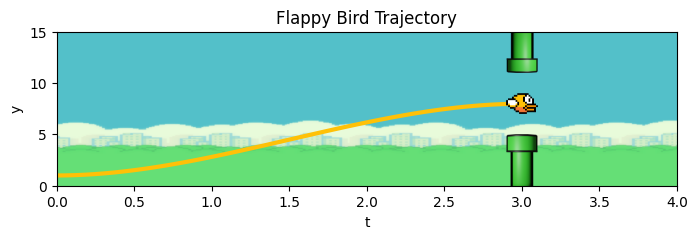

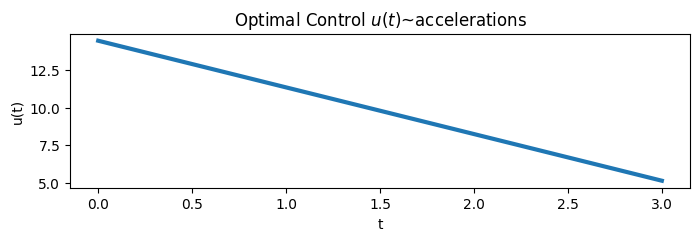

In [7]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 3
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 9.8
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    u = p1
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = p0_end
    ])

# setup an intial guess for the solution
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.ones(t_steps)
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0)

# extract the values from the solution
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
u = p1

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, 4)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = ylims[0], L
img = mpimg.imread('images/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = 2.9, 3.1
ymin, ymax = 7, 9
bird = mpimg.imread('images/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$~accelerations")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.gcf().set_size_inches(8,2)
plt.show()